_This notebook serves as a scratchpad used during development_

In [1]:
import jenn
import numpy as np 
import matplotlib.pyplot as plt 

TODO: 
    
- unit tests 
- linting 
- regular NN class + check speed up 
- typing (mypy) 
- add gradient-enhancement  
- mini-batch
- cross-validation 
- interactive goodness of fit and profiler (separate project)
- docstr + docs 
- release / CICD / conda packaging 

---
# Activation Functions

In [2]:
ACTIVATIONS = dict(
    relu=jenn.activation.Relu,
    tanh=jenn.activation.Tanh,
    linear=jenn.activation.Linear,
)

In [3]:
ACTIVATION_KEY = 'tanh'
x = np.linspace(-10, 10, 100_000)
g = ACTIVATIONS[ACTIVATION_KEY]

In [4]:
%%timeit

y = np.zeros(x.shape)
dy = np.zeros(x.shape)
ddy = np.zeros(x.shape)

id_y = id(y)
id_dy = id(dy)
id_ddy = id(ddy)
    
y = g.evaluate(x, y)
dy = g.first_derivative(x, y, dy)
ddy = g.second_derivative(x, y, dy, ddy)

assert id(y) == id_y
assert id(dy) == id_dy
assert id(ddy) == id_ddy

2.49 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%timeit 

y = np.zeros(x.shape)
dy = np.zeros(x.shape)
ddy = np.zeros(x.shape)

id_y = id(y)
id_dy = id(dy)
id_ddy = id(ddy)

y = g.evaluate(x)
dy = g.first_derivative(x)
ddy = g.second_derivative(x)

assert id(y) != id_y
assert id(dy) != id_dy
assert id(ddy) != id_ddy

7.17 ms ± 795 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


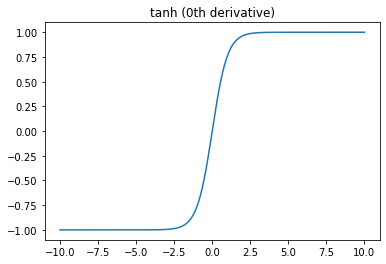

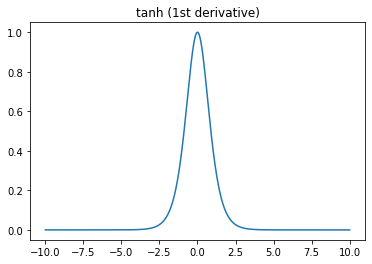

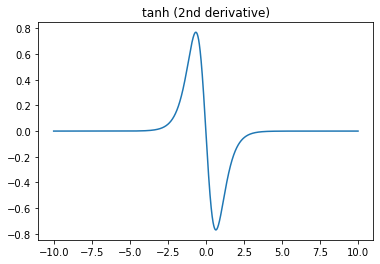

In [6]:
y = np.zeros(x.shape)
dy = np.zeros(x.shape)
ddy = np.zeros(x.shape)
    
y = g.evaluate(x, y)
dy = g.first_derivative(x, y, dy)
ddy = g.second_derivative(x, y, dy, ddy)

plt.plot(x, y)
plt.title(ACTIVATION_KEY + f" (0th derivative)")
plt.show()

plt.plot(x, dy)
plt.title(ACTIVATION_KEY + f" (1st derivative)")
plt.show()

plt.plot(x, ddy)
plt.title(ACTIVATION_KEY + f" (2nd derivative)")
plt.show()

---
# Forward Propagation

In [7]:
def test_xor(): 
    """Test forward propagation against XOR."""
    X = np.array([
        [0, 1, 0, 1], 
        [0, 0, 1, 1]
    ])
    
    cache = jenn.Cache(layer_sizes=[2, 2, 1], m=X.shape[1])
    
    parameters = jenn.Parameters(cache.layer_sizes, output_activation='relu')
    parameters.b[1][:] = np.array([[0], [-1]])       # layer 1
    parameters.W[1][:] = np.array([[1, 1], [1, 1]])  # layer 1
    parameters.b[2][:] = np.array([[0]])             # layer 2
    parameters.W[2][:] = np.array([[1, -2]])         # layer 2

    computed = jenn.model_forward(X, parameters, cache)
    expected = np.array([[0, 1, 1, 0]])

    assert (computed == expected).all(), f'computed = {computed} vs. expected = {expected}'
    
test_xor()

---
# Cost Function

In [8]:
def synthetic_data(m_train=4, m_test=30): 
    f = lambda x: x * np.sin(x)
    df_dx = lambda x: np.sin(x) + x * np.cos(x) 

    # Domain 
    lb = -np.pi
    ub = np.pi

    # Training data 
    m = m_train    # number of training examples
    n_x = 1  # number of inputs
    n_y = 1  # number of outputs
    X_train = np.linspace(lb, ub, m).reshape((n_x, m))
    Y_train = f(X_train).reshape((n_y, m))
    J_train = df_dx(X_train).reshape((n_y, n_x, m))

    # Test data 
    m = m_test  # number of test examples
    X_test = lb + np.random.rand(m, 1).reshape((n_x, m)) * (ub - lb)
    Y_test = f(X_test).reshape((n_y, m))
    J_test = df_dx(X_test).reshape((n_y, n_x, m))

    training_data = jenn.Dataset(X_train, Y_train, J_train) 
    test_data = jenn.Dataset(X_test, Y_test, J_test)
    
    return training_data, test_data

In [9]:
data, _ = synthetic_data()

In [10]:
def test_cost():
    data, _ = synthetic_data() 
    
    parameters = jenn.Parameters(layer_sizes=[2, 2, 1])
    cost = jenn.Cost(data, parameters, lambd=0.0)

    assert cost.evaluate(Y_pred=data.Y) == 0
    assert cost.evaluate(Y_pred=data.Y + np.random.rand()) != 0

test_cost()
# TODO: better test, with and without regularization, using data for which cost value is known 

---
# Finite Difference

In [11]:
parameters = jenn.Parameters([2, 2, 1])

parameters.W[0][:] = 1.
parameters.b[0][:] = 1.
parameters.W[1][:] = 1.
parameters.b[1][:] = 1.
parameters.W[2][:] = 1.
parameters.b[2][:] = 1.

x = parameters.stack()
x

[array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]),
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]),
 array([[1.],
        [1.],
        [1.]])]

In [12]:
def f(x):
    y = 0 
    for i in range(len(x)): 
        y += np.sum(x[i]**2) 
    return y

f(x)

15.0

In [13]:
def dfdx(x):
    dydx = []
    for i in range(len(x)): 
        dydx.append(2 * x[i]) 
    return dydx

dfdx(x)

[array([[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]]),
 array([[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]]),
 array([[2.],
        [2.],
        [2.]])]

In [14]:
jenn.finite_diff(f, x)

[array([[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]]),
 array([[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]]),
 array([[2.],
        [2.],
        [2.]])]

In [15]:
jenn.grad_check(
    dydx=dfdx(x),
    dydx_FD=jenn.finite_diff(f, x), 
)

The gradients of layer 0 are correct
Finite dif: grad[0] = [2. 2. 2. 2. 2. 2.]
Analytical: grad[0] = [2. 2. 2. 2. 2. 2.]

The gradients of layer 1 are correct
Finite dif: grad[1] = [2. 2. 2. 2. 2. 2.]
Analytical: grad[1] = [2. 2. 2. 2. 2. 2.]

The gradients of layer 2 are correct
Finite dif: grad[2] = [2. 2. 2.]
Analytical: grad[2] = [2. 2. 2.]



True

---
# Backward Propagation

In [16]:
X = np.array([
    [0, 1, 0, 1], 
    [0, 0, 1, 1]
])
Y_true = np.array([[0, 1, 1, 0]])

cache = jenn.Cache(layer_sizes=[2, 2, 1], m=X.shape[1])

parameters = jenn.Parameters(cache.layer_sizes, output_activation='relu')
parameters.b[1][:] = 1.0
parameters.W[1][:] = 1.0
parameters.b[2][:] = 1.0
parameters.W[2][:] = 1.0

data = jenn.Dataset(X, Y_true)
cost = jenn.Cost(data, parameters)

def cost_FD(x): 
    parameters.unstack(x)
    Y_pred = jenn.model_forward(X, parameters, cache)[0]
    return cost.evaluate(Y_pred)
    

assert cost_FD(x=parameters.stack()) != 0.0

# parameters.b[1][:] = np.array([[0], [-1]])       # layer 1
# parameters.W[1][:] = np.array([[1, 1], [1, 1]])  # layer 1
# parameters.b[2][:] = np.array([[0]])             # layer 2
# parameters.W[2][:] = np.array([[1, -2]])         # layer 2

# assert cost_FD(x=parameters.stack()) == 0.0

partials = jenn.finite_diff(cost_FD, parameters.stack())
parameters.unstack_partials(partials)
parameters.dW, parameters.db

([array([[0., 0.],
         [0., 0.]]),
  array([[2.75, 2.75],
         [2.75, 2.75]]),
  array([[10., 10.]])],
 [array([[0.],
         [0.]]),
  array([[4.5],
         [4.5]]),
  array([[4.5]])])

In [17]:
jenn.model_backward(data, parameters, cache)
parameters.dW, parameters.db

([array([[0., 0.],
         [0., 0.]]),
  array([[2.7499995, 2.7499995],
         [2.7499995, 2.7499995]]),
  array([[9.999998, 9.999998]])],
 [array([[0.],
         [0.]]),
  array([[4.499999],
         [4.499999]]),
  array([[4.499999]])])

---

# Sinusoid

In [18]:
def sinusoidal_data_1D(
        m_train=4, m_test=100, lb=-np.pi, ub=np.pi,
):
    """Generate 1D sinusoidal synthetic data."""

    def f(x):
        return x * np.sin(x)

    def dfdx(x):
        return np.sin(x) + x * np.cos(x)

    # Training data
    m = m_train  # number of training examples
    n_x = 1  # number of inputs
    n_y = 1  # number of outputs
    X_train = np.linspace(lb, ub, m).reshape((n_x, m))
    Y_train = f(X_train).reshape((n_y, m))
    J_train = dfdx(X_train).reshape((n_y, n_x, m))

    # Test data
    m = m_test  # number of test examples
    X_test = lb + np.random.rand(m, 1).reshape((n_x, m)) * (ub - lb)
    Y_test = f(X_test).reshape((n_y, m))
    J_test = dfdx(X_test).reshape((n_y, n_x, m))

    training_data = jenn.Dataset(X_train, Y_train, J_train)
    test_data = jenn.Dataset(X_test, Y_test, J_test)

    return training_data, test_data

In [19]:
train, test = sinusoidal_data_1D()

In [20]:
nn = jenn.NeuralNet([1, 12, 1], 'tanh')

In [21]:
# %%timeit

nn.fit(train.X, train.Y, train.J, batch_size=None, epochs=1, max_iter=500, lambd=0.0, gamma=1.0, alpha=0.01, is_normalize=True)

In [22]:
Y_pred = nn.predict(test.X)

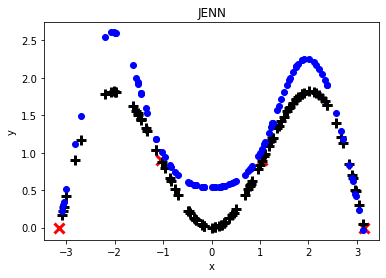

In [23]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.plot(train.X.ravel(), train.Y.ravel(), 'rx', mew=3, ms=10)
ax.plot(test.X.ravel(), test.Y.ravel(), 'k+', mew=3, ms=10)
ax.plot(test.X.ravel(), Y_pred.ravel(), 'bo')
# ax.plot(X, Y_true, 'k--')
# ax.plot(X_test, Y_test, 'ro')
ax.set(xlabel='x', ylabel='y', title='JENN')
# ax.legend(['Predicted', 'True', 'Test', 'Train'])
plt.show()

In [ ]:
import numpy as np


# Not an efficient implementation, but okay for testing
def _forward_difference(f: callable, x: np.ndarray, dx: float = 1e-6):
    """Compute partials of y = f(x) using forward difference."""
    n_x, m = x.shape
    dy = np.zeros((n_x, m))
    for i in range(0, n_x):
        dy[i] = np.divide(f(x+dx) - f(x), dx)
    return dy


# Not an efficient implementation, but okay for testing
def _backward_difference(f: callable, x: np.ndarray, dx: float = 1e-6):
    """Compute partials of y = f(x) using backward difference."""
    n_x, m = x.shape
    dy = np.zeros((n_x, m))
    for i in range(0, n_x):
        dy[i] = np.divide(f(x) - f(x-dx), dx)
    return dy


# Not an efficient implementation, but okay for testing
def _central_difference(f: callable, x: np.ndarray, dx: float = 1e-6):
    """Compute partials of y = f(x) using central difference."""
    n_x, m = x.shape
    dy = np.zeros((n_x, m))
    for i in range(0, n_x):
        dy[i] = np.divide(f(x+dx) - f(x-dx), 2 * dx)
    return dy


def finite_difference(f: callable, x: np.ndarray, dx: float = 1e-6):
    """Compute partials of y = f(x) using ctr, fwd or bwd difference."""
    dy = _central_difference(f, x, dx)
    dy[:, :1] = _forward_difference(f, x, dx)[:, :1]
    dy[:, -1:] = _backward_difference(f, x, dx)[:, -1:]
    return dy

In [ ]:
f = lambda x: nn.predict(x)[0]
finite_difference(f, train.X, dx=1e-6)  # TODO: unit test 

### Units Test

* 1D sinusoid
* 2D rastrigin 
* Optimizer (rosenbrock)

# DevOPs 

* Setup CI 
* Setup QA 
* Conda release 
* Typing

### Features 

* Upgrade Python 
* Goodness of fit reporting 
* Sensitivity profilers / contours / interactivity 
* Make API backwards compatible 
* Exporting / Importing a model 
* Turn off partial computation when not needed 

# Examples 

* Rastrigin notebook 
* Sinusoid notebook 

# Documentation 

* Theory 
* API 
* Docstr

# Analysis 

* Benchmarking / scalability 